In [0]:
import matplotlib.pyplot as plt
import urllib.request
from PIL import Image
import numpy as np
import subprocess
import json
import PIL
import os
from PIL import Image
import PIL.ImageOps
from matplotlib import cm
from google.colab import files
import shutil

from torch import nn, Tensor
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
from sklearn.preprocessing import StandardScaler

In [0]:
from google.colab import drive
root_dir = '/content/drive/'
drive.mount(root_dir, force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
base_dir = root_dir + 'My Drive/ML_Project/Dataset'

file_names = os.listdir(base_dir)
print(file_names)

['tree.npy', 't-shirt.npy', 'ice cream.npy', 'fish.npy', 'face.npy', 'car.npy', 'bowtie.npy', 'apple.npy', 'flamingo.npy', 'sheep.npy']


In [0]:
classes = ['tree.npy', 't-shirt.npy', 'ice cream.npy', 'fish.npy', 'face.npy', 'car.npy', 'bowtie.npy', 'apple.npy', 'flamingo.npy', 'sheep.npy']


In [0]:
def save_png(rows=5):
    num_classes = len(classes)
    '''
    Converts the npy array to png
    '''
    c = 1 #THE CLASS YOU WANT TO CONVERT
    arr = np.load(f'{root_dir}/My Drive/ML_Project/Dataset/{classes[c]}.npy')    

    print('CONVERTING CLASS ',classes[c])

    rows = len(arr)
    os.mkdir(classes[c])
    for i in range(rows): 
      inv_myarray = arr[i, :784].reshape((28,28))
      ones = np.ones((28,28))
      myarray = ones-inv_myarray
      im = Image.fromarray(np.uint8(cm.gray(myarray)*255)).convert('RGB')
      filename = classes[c]+'/img'+"{:07n}".format(i)+'.png'
      im.save(filename, "PNG")

In [0]:
def load_data(batch_size = 128):
    """
    Returns a list of PyTorch DataLoaders in order of train, validation, and test loaders
    """
    dirnames = [root_dir + 'My Drive/ML_Project/Train/', root_dir + 'My Drive/ML_Project/Validation/', root_dir + 'My Drive/ML_Project/Test/']
    loaders = []

    scaler = StandardScaler()
    for dirname in dirnames:
        dataname = os.listdir(dirname)[0]
        X = np.load(dirname + dataname)['data'].reshape(-1, 28, 28)
        ys = np.load(dirname + dataname)['target']

        xs = np.copy(X)
        for sample in range(len(X)):
            samplex = X[sample,:,:]
            xs[sample,:,:] = scaler.fit_transform(samplex)

        print(f'Loading {dataname} into Pytorch Dataloader ... Xs shape: {xs.shape}, Ys shape: {ys.shape}')
        loaders.append(DataLoader(TensorDataset(Tensor(xs), Tensor(ys)), batch_size = batch_size, shuffle=True))
    
    return loaders

In [0]:
def plot_samples(xs, ys, batch_size = 256, rows = 2):
    classes = ['tree.npy', 't-shirt.npy', 'ice cream.npy', 'fish.npy', 'face.npy', 'car.npy', 'bowtie.npy', 'apple.npy', 'flamingo.npy', 'sheep.npy']
    num_classes = len(classes)
    '''
    Plots row number of samples from each class
    '''

    fig, axs = plt.subplots(figsize=(num_classes,rows))
    axs.axis('off')
    xs = xs.reshape(xs.shape[0], 28, 28)
    
    for i in range(rows * num_classes): 
        c = i % num_classes
        class_indices = np.argwhere(ys == c).squeeze()
        ci = i % len(class_indices)
        curr = class_indices[ci]
        
        a = fig.add_subplot(rows, num_classes, i + 1)

        imgplot = plt.imshow(xs[curr, :].reshape((28, 28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])
    plt.show()

VAE Model

In [0]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class VAE_all_class(nn.Module):
    def __init__(self, Nz):
        """
        Nz is the number of latent features network is trying to learn
        """
        super(VAE_all_class, self).__init__()
        self.Nz = Nz

        # Encoder: 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=1)
        self.mp = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(3 * 14 * 14, Nz)
        self.fc2 = nn.Linear(3 * 14 * 14, Nz)
        
        self.up1 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pad1 = nn.ReplicationPad2d(1)

        # Decoder:
        self.l1 = nn.Linear(Nz, 3 * 14 * 14)
        self.up1 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pad1 = nn.ReplicationPad2d(1)
        self.d_conv1 = nn.Conv2d(3, 1, 3, 1)
        self.sigmoid = nn.Sigmoid()
    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.mp(F.relu(self.conv3(x)))
        # Resize from (batch_size, num_classes, w, h) to (batch_size,num_classes*w*h)
        x = x.view(x.shape[0], -1)

        mu = F.relu(self.fc1(x))
        logvar = F.relu(self.fc2(x))
        return mu, logvar
    
    def decode(self, latent):
        x = F.relu(self.l1(latent))
        
        x = x.view(-1, 3, 14, 14)
        
        x = F.relu(self.pad1(self.up1(x)))
        x = self.sigmoid(self.d_conv1(x))
        return x
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, image):
        mu, logvar = self.encode(image)
        lz = self.reparameterize(mu, logvar)
        im = self.decode(lz)
        return im, mu, logvar

Loss Function

In [0]:
def loss_function(z_img, img, mu, logvar):
    """
    VAE loss without the KL divergence
    """
    #img = torch.from_numpy(img)
    img = img.view(-1,28*28)

    return F.binary_cross_entropy(z_img, img, reduction='sum')

In [0]:
vae_model = VAE_all_class(1000)

In [0]:
checkpoint = torch.load('/content/drive/My Drive/ML_Project/vae_2.pt')
vae_model.load_state_dict(checkpoint)

<All keys matched successfully>

Train the model

Loading Train.npz into Pytorch Dataloader ... Xs shape: (84000, 28, 28), Ys shape: (84000,)
Loading Validation.npz into Pytorch Dataloader ... Xs shape: (36000, 28, 28), Ys shape: (36000,)
Loading Test.npz into Pytorch Dataloader ... Xs shape: (30000, 28, 28), Ys shape: (30000,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Using a target size (torch.Size([256, 784])) that is different to the input size (torch.Size([256, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  


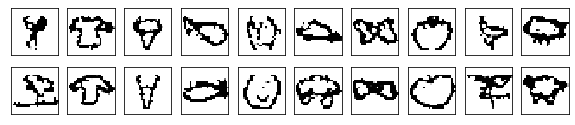

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Using a target size (torch.Size([32, 784])) that is different to the input size (torch.Size([32, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  


Epoch 1  | Training loss: -2109742.11
Epoch 2  | Training loss: -2111225.46
Epoch 3  | Training loss: -2111805.37
Epoch 4  | Training loss: -2112638.74
Epoch 5  | Training loss: -2113111.06
Epoch 6  | Training loss: -2113797.01
Epoch 7  | Training loss: -2114176.82
Epoch 8  | Training loss: -2114767.84
Epoch 9  | Training loss: -2115043.20
Epoch 10  | Training loss: -2115683.06


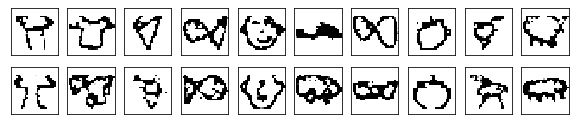

Epoch 11  | Training loss: -2116132.88
Epoch 12  | Training loss: -2116570.84
Epoch 13  | Training loss: -2117171.49
Epoch 14  | Training loss: -2117842.06
Epoch 15  | Training loss: -2118281.23
Epoch 16  | Training loss: -2118573.28
Epoch 17  | Training loss: -2118908.74
Epoch 18  | Training loss: -2119196.08
Epoch 19  | Training loss: -2119418.64
Epoch 20  | Training loss: -2115974.47


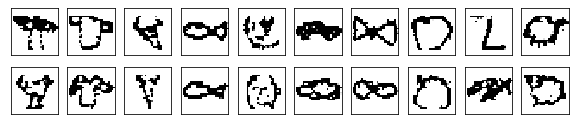

Epoch 21  | Training loss: -2117766.83
Epoch 22  | Training loss: -2119735.78
Epoch 23  | Training loss: -2120797.03
Epoch 24  | Training loss: -2121147.15
Epoch 25  | Training loss: -2121381.88
Epoch 26  | Training loss: -2122049.75
Epoch 27  | Training loss: -2122416.19
Epoch 28  | Training loss: -2122874.33
Epoch 29  | Training loss: -2123329.24
Epoch 30  | Training loss: -2123523.46


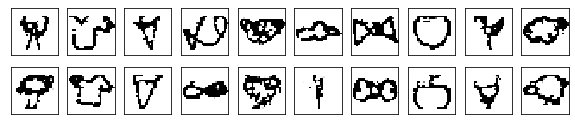

Epoch 31  | Training loss: -2124092.78
Epoch 32  | Training loss: -2124258.64
Epoch 33  | Training loss: -2122424.24
Epoch 34  | Training loss: -2127623.97
Epoch 35  | Training loss: -2128352.19
Epoch 36  | Training loss: -2128467.88
Epoch 37  | Training loss: -2128925.05
Epoch 38  | Training loss: -2129226.65
Epoch 39  | Training loss: -2129612.77
Epoch 40  | Training loss: -2129693.39


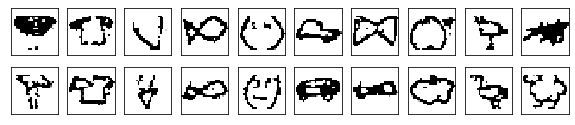

Epoch 41  | Training loss: -2129912.54
Epoch 42  | Training loss: -2130142.34
Epoch 43  | Training loss: -2127493.42
Epoch 44  | Training loss: -2129819.69
Epoch 45  | Training loss: -2130268.94
Epoch 46  | Training loss: -2130582.09
Epoch 47  | Training loss: -2130809.79
Epoch 48  | Training loss: -2130711.44
Epoch 49  | Training loss: -2131064.51
Epoch 50  | Training loss: -2130883.71


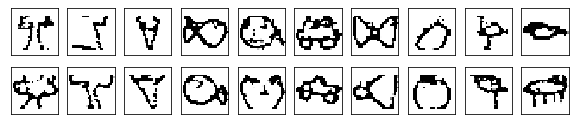

Epoch 51  | Training loss: -2136974.98
Epoch 52  | Training loss: -2141020.97
Epoch 53  | Training loss: -2142101.87
Epoch 54  | Training loss: -2142192.12
Epoch 55  | Training loss: -2142704.78
Epoch 56  | Training loss: -2142767.22
Epoch 57  | Training loss: -2143063.49
Epoch 58  | Training loss: -2143102.10
Epoch 59  | Training loss: -2143298.03
Epoch 60  | Training loss: -2143592.33


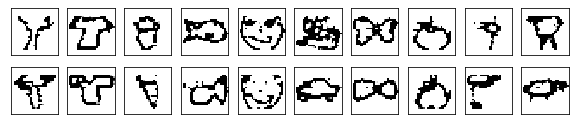

Epoch 61  | Training loss: -2143735.03
Epoch 62  | Training loss: -2143770.69
Epoch 63  | Training loss: -2142632.34
Epoch 64  | Training loss: -2144932.80
Epoch 65  | Training loss: -2145454.96
Epoch 66  | Training loss: -2145857.33
Epoch 67  | Training loss: -2146342.67
Epoch 68  | Training loss: -2146644.17
Epoch 69  | Training loss: -2146891.59
Epoch 70  | Training loss: -2147106.35


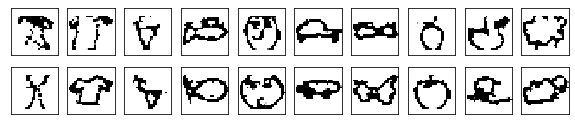

Epoch 71  | Training loss: -2147229.83
Epoch 72  | Training loss: -2147357.36
Epoch 73  | Training loss: -2147828.50
Epoch 74  | Training loss: -2147905.71
Epoch 75  | Training loss: -2148267.45
Epoch 76  | Training loss: -2148396.88
Epoch 77  | Training loss: -2148435.30
Epoch 78  | Training loss: -2148542.69
Epoch 79  | Training loss: -2148718.08
Epoch 80  | Training loss: -2147866.45


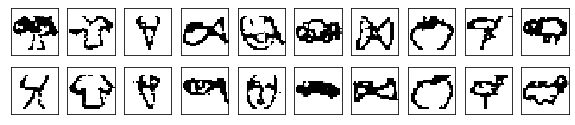

Epoch 81  | Training loss: -2148941.58
Epoch 82  | Training loss: -2149136.42
Epoch 83  | Training loss: -2149037.71
Epoch 84  | Training loss: -2149323.17
Epoch 85  | Training loss: -2149154.13
Epoch 86  | Training loss: -2148567.94
Epoch 87  | Training loss: -2155622.72
Epoch 88  | Training loss: -2158576.61
Epoch 89  | Training loss: -2159277.19
Epoch 90  | Training loss: -2160152.05


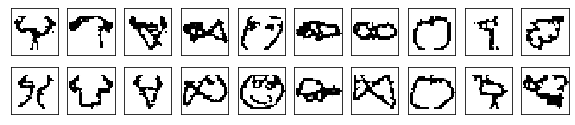

Epoch 91  | Training loss: -2160600.84
Epoch 92  | Training loss: -2161021.90
Epoch 93  | Training loss: -2161771.79
Epoch 94  | Training loss: -2161868.05
Epoch 95  | Training loss: -2162223.26
Epoch 96  | Training loss: -2162657.55
Epoch 97  | Training loss: -2162702.55
Epoch 98  | Training loss: -2163168.05
Epoch 99  | Training loss: -2163641.19
Epoch 100  | Training loss: -2163610.83


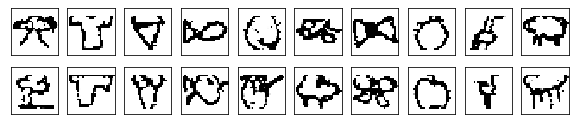

Epoch 101  | Training loss: -2163971.41
Epoch 102  | Training loss: -2166260.57
Epoch 103  | Training loss: -2169012.29
Epoch 104  | Training loss: -2169779.76
Epoch 105  | Training loss: -2170377.39
Epoch 106  | Training loss: -2171033.51
Epoch 107  | Training loss: -2171064.74
Epoch 108  | Training loss: -2171605.29
Epoch 109  | Training loss: -2171347.68
Epoch 110  | Training loss: -2171755.52


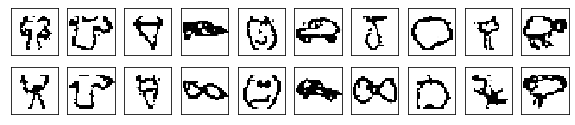

Epoch 111  | Training loss: -2169814.98
Epoch 112  | Training loss: -2171886.25
Epoch 113  | Training loss: -2172739.55
Epoch 114  | Training loss: -2172512.76
Epoch 115  | Training loss: -2172919.92
Epoch 116  | Training loss: -2173074.39
Epoch 117  | Training loss: -2173030.87


In [0]:
epochs = 500 # plus 129 previous epochs
trainloader, validloader, testloader  = load_data(batch_size = 256)
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

for epoch in range(epochs):
    avg_loss = 0.0
    for i, (xs, ys) in enumerate(trainloader):
        optimizer.zero_grad()
        z_img, mu, logvar = vae_model(xs.unsqueeze(dim=1))
        loss = loss_function(z_img, xs, mu, logvar)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        
        if epoch % 10 == 0 and i == len(trainloader) - 2:
            plot_samples(z_img.detach().numpy(), ys)
        if epoch % 5 == 0 and i == len(trainloader) - 1:
            torch.save(vae_model.state_dict(), '/content/drive/My Drive/ML_Project/vae_2.pt')
    
    print(f'Epoch {epoch+1}  | Training loss: {avg_loss / len(trainloader) : .2f}')


In [0]:
plot_samples(z_img.detach().numpy(), ys)

In [0]:
torch.save(vae_model.state_dict(), '/content/drive/My Drive/ML_Project/vae_2.pt')

In [0]:
for epoch in range(500, 1001):
    avg_loss = 0.0
    for i, (xs, ys) in enumerate(trainloader):
        optimizer.zero_grad()
        z_img, mu, logvar = vae_model(xs.unsqueeze(dim=1))
        loss = loss_function(z_img, xs, mu, logvar)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        
        if epoch % 20 == 0 and i == len(trainloader) - 2:
            torch.save(vae_model.state_dict(), '/content/drive/My Drive/ML_Project/vae.pt')
            plot_samples(z_img.detach().numpy(), ys)
    
    print(f'\nEpoch {epoch}  | Training loss: {avg_loss / len(trainloader) : .2f}')
